In [1]:
import tensorflow as tf
import pandas as pd
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)


In [2]:
df = pd.read_csv('df_train_clean_lemma.csv')
df.head()

,text,target,text_clean
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason hastag earthquake allah forgive
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...
3,"13,000 people receive #wildfires evacuation or...",1,13000 people receive hastag wildfire evacuatio...
4,Just got sent this photo from Ruby #Alaska as ...,1,send photo ruby hastag alaska smoke hastag wil...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        7613 non-null   object
 1   target      7613 non-null   int64 
 2   text_clean  7612 non-null   object
dtypes: int64(1), object(2)
memory usage: 178.6+ KB


In [4]:
tokenize = tf.keras.preprocessing.text.Tokenizer()

In [5]:
df.text_clean = df.text_clean.astype(str)

In [6]:
tokenize.fit_on_texts(df.text_clean)
df['text_tokenize'] = tokenize.texts_to_sequences(df.text_clean)
df.head()

,text,target,text_clean,text_tokenize
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason hastag earthquake allah forgive,"[3675, 422, 1, 168, 1251, 1952]"
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[114, 3, 157, 503, 5525, 5526, 950]"
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...,"[1369, 443, 1706, 316, 5527, 286, 180, 1706, 3..."
3,"13,000 people receive #wildfires evacuation or...",1,13000 people receive hastag wildfire evacuatio...,"[2307, 5, 2308, 1, 68, 180, 287, 33]"
4,Just got sent this photo from Ruby #Alaska as ...,1,send photo ruby hastag alaska smoke hastag wil...,"[174, 120, 5528, 1, 1707, 165, 1, 68, 2309, 105]"


In [7]:
padded = tf.keras.preprocessing.sequence.pad_sequences(df.text_tokenize, padding="post")

In [8]:
tensor_df = tf.data.Dataset.from_tensor_slices((padded, df.target.values))

In [9]:
TAKE_SIZE = int(0.7*df.shape[0])
BATCH_SIZE = 16

train_data = tensor_df.take(TAKE_SIZE).shuffle(TAKE_SIZE)
train_data = train_data.batch(BATCH_SIZE)

test_data = tensor_df.skip(TAKE_SIZE).shuffle(df.shape[0]-TAKE_SIZE)
test_data = test_data.batch(BATCH_SIZE)

In [10]:
for train, target in train_data.take(1):
    print(train)
    print(target)

tf.Tensor(
[[   66     2  8501  8502     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [  468     5   494  6525    26  6526   470    75  6527  3971  6528     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    1   113   778   419   478   174   568   196    89   115   594   147
      1   420     1    16     0     0     0     0     0     0     0     0
      0     0     0     0]
 [  145   343   110   273    60  6269   849  1770     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [  301   798  1651    46   130  2719     3     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [ 2130   394   346   164   221  5254  3053   379  5255   379     1 13061
      1 13062     0     0     0     0   

In [11]:
vocab_size=len(tokenize.word_index)
vocab_size

15998

In [12]:
model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size+1, 128, input_shape=[train.shape[1]]),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(2, activation='softmax')
])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 28, 128)           2047872   
_________________________________________________________________
dropout (Dropout)            (None, 28, 128)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 24, 64)            41024     
_________________________________________________________________
batch_normalization (BatchNo (None, 24, 64)            256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                9

In [14]:
initial_learning_rate = 0.0001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=250,
    decay_rate=0.96,
    staircase=True)

optimizer= tf.keras.optimizers.Adam(
    learning_rate =  lr_schedule
)

In [15]:
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [16]:
history = model.fit(train_data, epochs=40, validation_data=test_data)

Epoch 1/40
334/334 [==============================] - 13s 16ms/step - loss: 0.8389 - sparse_categorical_accuracy: 0.5282 - val_loss: 0.6933 - val_sparse_categorical_accuracy: 0.4847
Epoch 2/40
334/334 [==============================] - 5s 14ms/step - loss: 0.7124 - sparse_categorical_accuracy: 0.5483 - val_loss: 0.6881 - val_sparse_categorical_accuracy: 0.5433
Epoch 3/40
334/334 [==============================] - 5s 14ms/step - loss: 0.7012 - sparse_categorical_accuracy: 0.5515 - val_loss: 0.6870 - val_sparse_categorical_accuracy: 0.5679
Epoch 4/40
334/334 [==============================] - 5s 14ms/step - loss: 0.6890 - sparse_categorical_accuracy: 0.5626 - val_loss: 0.6859 - val_sparse_categorical_accuracy: 0.5771
Epoch 5/40
334/334 [==============================] - 5s 15ms/step - loss: 0.6765 - sparse_categorical_accuracy: 0.5632 - val_loss: 0.6823 - val_sparse_categorical_accuracy: 0.5849
Epoch 6/40
334/334 [==============================] - 5s 14ms/step - loss: 0.6854 - sparse_cat

In [17]:
import matplotlib.pyplot as plt

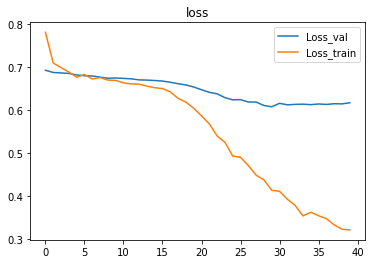

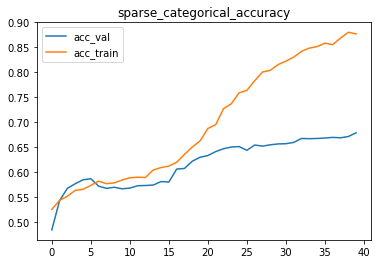

In [18]:
loss_curve = history.history["loss"]
loss_val = history.history["val_loss"]
acc_curve = history.history["sparse_categorical_accuracy"]
acc_val = history.history["val_sparse_categorical_accuracy"]

plt.plot(loss_val,label="Loss_val")
plt.plot(loss_curve,label="Loss_train")
plt.legend()
plt.title("loss")
plt.show()

plt.plot(acc_val, label="acc_val" )
plt.plot(acc_curve, label="acc_train" )
plt.legend()
plt.title("sparse_categorical_accuracy")
plt.show()